# Projeto de Classificação para Marinha do Brasil

## Autor: Natanael Junior (natmourajr@gmail.com)

Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM

In [2]:
import os
import pickle
import numpy as np
import time

from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'SingleClassSVM'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/picts'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = True
development_events = 100

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 0.000139951705933 seconds
Time to read data file: 5.59633708 seconds


Using TensorFlow backend.


Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events


In [99]:
from sklearn import preprocessing
from sklearn import svm

def SVMNoveltyTrainFunction(data=None, trgt=None, inovelty=0, 
                            ifold=0, n_folds=2, nu_value=0.5, 
                            trn_params=None, save_path='',
                            verbose=False, dev=False):
    
    # load or create cross validation ids
    CVO = trnparams.NoveltyDetectionFolds(folder=save_path,n_folds=n_folds,trgt=trgt,dev=dev)
    
    model_prefix_str = 'RawData_%i_novelty'%(inovelty)
    analysis_path = 'SingleClassSVM'
    nu_value_str = ('%1.5f'%nu_value).replace('.','_')
    
    params_str = trn_params.get_params_str()
    
    model_str = '%s/%s/%s_%i_folds_%s_%s_nu_value'%(save_path,analysis_path,
                                                    model_prefix_str,
                                                    n_folds,
                                                    params_str,
                                                    nu_value_str)
    if not development_flag:
        file_name = '%s_%i_fold_model.jbl'%(model_str,ifold)
    else:
        file_name = '%s_%i_fold_model_dev.jbl'%(model_str,ifold)
        
    if verbose:
        print file_name
    
    if not os.path.exists(file_name):
        # training
        
        classifiers = {}
        novelty_detector = []
        
        train_id, test_id = CVO[inovelty][ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])

        norm_data = scaler.transform(data)
        
        # class specialist
        for iclass, m_class in enumerate(np.unique(trgt)):
            classifiers[iclass] = svm.OneClassSVM(nu=nu_value, 
                                                  kernel=trn_params.params['kernel'], 
                                                  gamma=trn_params.params['gamma'])
            classifiers[iclass].fit(norm_data[trgt==m_class])
        novelty_detector = svm.OneClassSVM(nu=nu_value, 
                                           kernel=trn_params.params['kernel'], 
                                           gamma=trn_params.params['gamma'])
        novelty_detector.fit(norm_data)
        if verbose:
            print 'saving file'
        joblib.dump([classifiers, novelty_detector],file_name,compress=9) 
    else:
        # loading
        if verbose:
            print 'file does exist'
        [classifiers, novelty_detector] = joblib.load(file_name)
    return classifiers, novelty_detector

In [146]:
# Train example


from Functions import TrainParameters as trnparams


analysis_str = 'SingleClassSVM'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.SVMNoveltyDetectionTrnParams(gamma=0.1)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.SVMNoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)


n_folds = 2
CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    for inu in np.arange(0.5,0.6,0.1):
        for ifold in range(len(CVO[inovelty])):
            print 'Novelty class: %01.0f - nu value: %01.3f - fold %i'%(novelty_class,inu, ifold)
            
            trn_data = all_data[all_trgt!=novelty_class]
            trn_trgt = all_trgt[all_trgt!=novelty_class]
            
            SVMNoveltyTrainFunction(data=trn_data, trgt=trn_trgt, inovelty=inovelty, 
                                    ifold=ifold, n_folds=len(CVO[inovelty]), nu_value=inu, 
                                    trn_params=trn_params, save_path=results_path, verbose=False,
                                    dev=True)
            
            

Novelty class: 0 - nu value: 0.500 - fold 0
Novelty class: 0 - nu value: 0.500 - fold 1
Novelty class: 1 - nu value: 0.500 - fold 0
Novelty class: 1 - nu value: 0.500 - fold 1
Novelty class: 2 - nu value: 0.500 - fold 0
Novelty class: 2 - nu value: 0.500 - fold 1
Novelty class: 3 - nu value: 0.500 - fold 0
Novelty class: 3 - nu value: 0.500 - fold 1


file exists


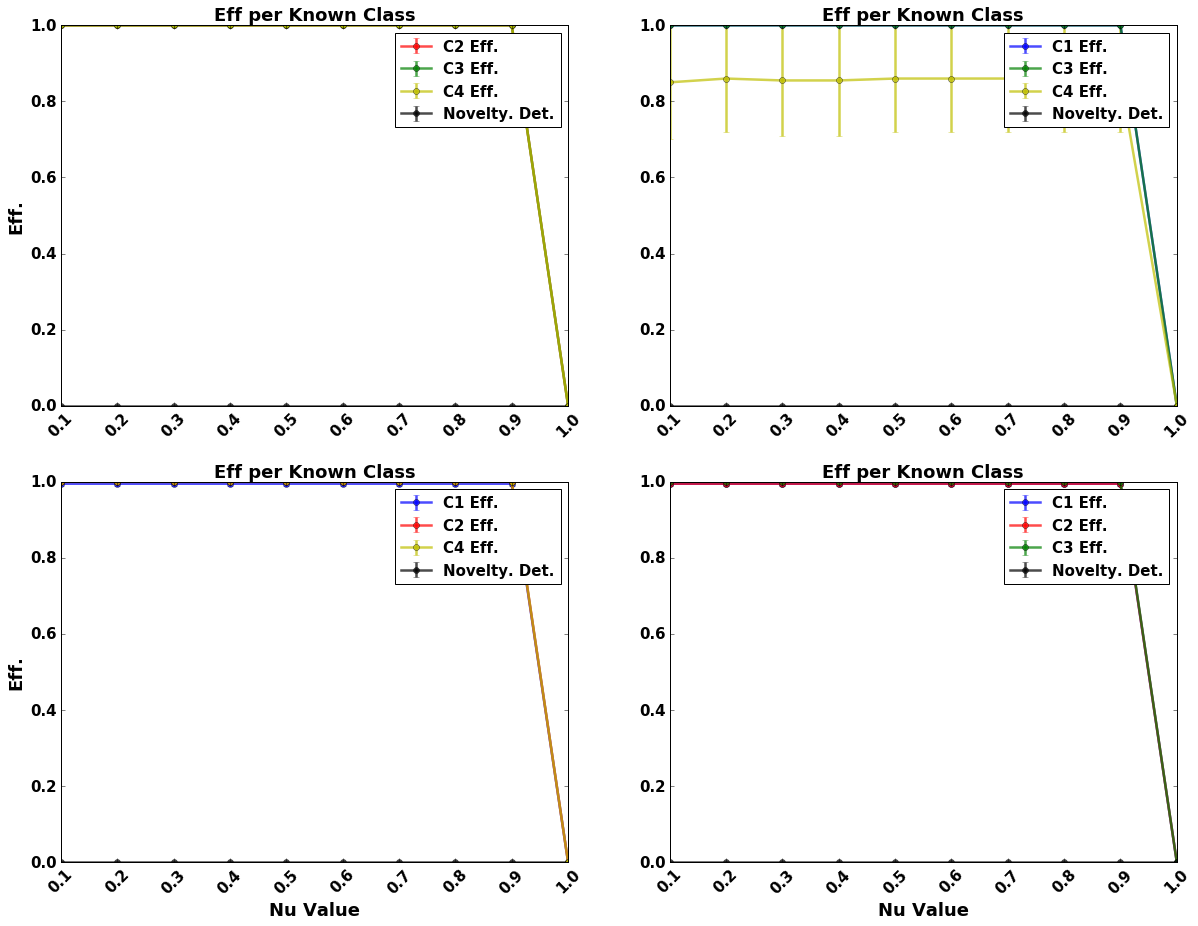

In [227]:
# analysis example - nu value variation

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

from keras.utils import np_utils
from keras.models import load_model

from Functions import TrainParameters as trnparams


# generate analysis data
save_path=results_path

analysis_str = 'SingleClassSVM'
model_prefix_str = 'RawData'

analysis_file_name='%s/%s/%s_nu_value_sweep.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
    
    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.SVMNoveltyDetectionTrnParams(gamma=0.011)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.SVMNoveltyDetectionTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = len(CVO[0])
    CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    nu_mat = np.arange(0.1,1.1,0.1)

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(nu_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(nu_mat)])

    for inovelty, novelty_class in enumerate(np.unique(trgt)):
        trn_data = all_data[all_trgt!=novelty_class]
        trn_trgt = all_trgt[all_trgt!=novelty_class]
        for ifold in range(len(CVO[inovelty])):
            for inu,nu_value in enumerate(nu_mat): 
                #print 'Novelty class: %01.0f - nu value: %01.3f - fold %i'%(novelty_class,nu_value, ifold)
                [classifiers,novelty_detector] = SVMNoveltyTrainFunction(data=trn_data, trgt=trn_trgt, inovelty=inovelty, 
                                                ifold=ifold, n_folds=len(CVO[inovelty]), nu_value=nu_value, 
                                                trn_params=trn_params, save_path=results_path, dev=True)
                
                for iclass, m_class in enumerate(np.unique(trn_trgt)):
                    if m_class == novelty_class:
                        output = novelty_detector.predict(all_data[all_trgt==novelty_class])
                        novelty_eff_mat[ifold,int(novelty_class),inu]= float(sum(output==-1.))/float(len(output))
                    else:
                        output = classifiers[iclass].predict(trn_data[trn_trgt==m_class])
                        class_eff_mat[ifold,int(novelty_class),int(m_class),inu] = float(sum(output==1.))/float(len(output))
    joblib.dump([class_eff_mat,novelty_eff_mat,nu_mat],analysis_file_name,compress=9)
else:
    print 'file exists'
    [class_eff_mat,novelty_eff_mat,nu_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=(20,15))

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(nu_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novelty. Det.')
        else:
            ax.errorbar(nu_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='C%i Eff.'%(int(m_class)+1))
    ax.set_xticks(nu_mat)
    ax.set_xticklabels(nu_mat,rotation=45)
    ax.set_title('Eff per Known Class',fontsize=18,weight='bold')
    if inovelty > 1:
        ax.set_xlabel('Nu Value',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Eff.',fontsize=18,weight='bold')
        
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=1)
    

In [45]:
# develop area

from Functions import NoveltyDetectionAnalysis as novelty_detection


def train_function_for_more_cores(fold):
        [data, trgt, nu_values, trn_info, n_folds] = joblib.load('./buffer.jbl')
        qtd_folds = n_folds
        qtd_classes = trgt.shape[1]
        qtd_nu = nu_values.shape[0]
        
        # to be easy to compare
        trgt_num = trgt.argmax(axis=1)
        
        # fig of merit
        eff_known_class = np.zeros([qtd_classes,qtd_classes-1,qtd_nu])
        tri_known_class = np.zeros([qtd_classes,qtd_nu])
        eff_novelty = np.zeros([qtd_classes,qtd_nu])
    
        for i_novelty_class in range(trgt.shape[1]):
            for i_nu, nu_value in enumerate(nu_values):
                print 'Fold: %i - Novelty: %i/%i - Nu: %i/%i'%(fold+1,
                                                               i_novelty_class+1,
                                                               qtd_classes,
                                                               i_nu+1,
                                                               qtd_nu)
                classifiers = obj.train(data, trgt, 
                                        novelty_class=i_novelty_class,
                                        trn_info=trn_info,
                                        nu_value=nu_value,
                                        fold=fold)
                for iclass in range(len(classifiers)):
                    if not iclass == i_novelty_class:
                        output = classifiers[iclass].predict(data)
                        eff_aux = float(sum(output[trgt_num==iclass]==1))/float(sum(trgt_num==iclass))
                        eff_known_class[i_novelty_class,iclass-(iclass>i_novelty_class),i_nu] = eff_aux
                    else:
                        # novelty detection
                        output = classifiers[i_novelty_class].predict(data)
                        eff_aux = float(sum(output[trgt_num==i_novelty_class]==-1))/float(sum(trgt_num==i_novelty_class))
                        eff_novelty[i_novelty_class,i_nu] = eff_aux
                                
                        # trigger
                        eff_aux = float(sum(output[trgt_num!=i_novelty_class]==1))/float(sum(trgt_num!=i_novelty_class))
                        tri_known_class[i_novelty_class,i_nu] = eff_aux
                        
        return [eff_known_class,tri_known_class,eff_novelty]

n_folds = 4
min_nu=0.1
max_nu=0.9 
nu_step=0.1 
num_cores=0

date = '2017_07_11_19_20_57'



obj = novelty_detection.SVMNoveltyDetection(name=analysis_name,
                                            preproc_path=files_results_path,
                                            train_path=files_results_path,
                                            anal_path=files_results_path)

obj.trn_info = novelty_detection.TrnInformation(date=date, n_folds=n_folds)
obj.trn_info.SplitTrainSet(all_trgt)

data = all_data
trgt = trgt_sparse

# checar se a analise ja foi feita
min_nu_str = ("%.5f"%(min_nu)).replace('.','_')
max_nu_str = ("%.5f"%(max_nu)).replace('.','_')
step_nu_str = ("%.5f"%(nu_step)).replace('.','_')
file_name = '%s/%s_%s_analysis_nu_sweep_min_%s_max_%s_step_%s.jbl'%(files_results_path,
                                                                    date,
                                                                    'develop',
                                                                    min_nu_str,
                                                                    max_nu_str,
                                                                    step_nu_str)

init_time = time.time()
if not os.path.exists(file_name):
    nu_values = np.arange(min_nu,max_nu+nu_step/2.0,nu_step)
    qtd_folds = n_folds
    qtd_classes = trgt.shape[1]
    qtd_nu = nu_values.shape[0]
    
    # to be easy to compare
    trgt_num = trgt.argmax(axis=1)
    
    # Figures of Merit
    # qtd_classes -1 = all known classes
    # qtd_classes = possible nolvety classes
    n_fig_merit = 3
    eff_known_class = np.zeros([qtd_folds,qtd_classes,qtd_classes-1,qtd_nu])
    tri_known_class = np.zeros([qtd_folds,qtd_classes,qtd_nu])
    eff_novelty = np.zeros([qtd_folds,qtd_classes,qtd_nu])
    
    
    # criar um arquivo temp para guardar os parametros
    args = './buffer.jbl'
    joblib.dump([data,trgt,nu_values,obj.trn_info,n_folds],'./buffer.jbl',compress=9)
    p = Pool(4)
    out =  p.map(train_function_for_more_cores,range(n_folds))
    
    for i in range(n_folds):
        [eff_known_class[i], tri_known_class[i], eff_novelty[i]] = out[i]
            
    
            
#     for ifold in range(n_folds):
#         for i_novelty_class in range(trgt.shape[1]):
#             for i_nu, nu_value in enumerate(nu_values):
#                 print 'Fold: %i/%i - Novelty: %i/%i - Nu: %i/%i'%(ifold+1,
#                                                                   qtd_folds,
#                                                                   i_novelty_class+1,
#                                                                   qtd_classes,
#                                                                   i_nu+1,
#                                                                   qtd_nu)
#                 classifiers = obj.train(data, trgt, 
#                                         novelty_class=i_novelty_class,
#                                         trn_info=obj.trn_info,
#                                         nu_value=nu_value,
#                                         fold=ifold)
#                 for iclass in range(len(classifiers)):
#                     if not iclass == i_novelty_class:
#                         output = classifiers[iclass].predict(data)
#                         eff_aux = float(sum(output[trgt_num==iclass]==1))/float(sum(trgt_num==iclass))
#                         eff_known_class[ifold,i_novelty_class,iclass-(iclass>i_novelty_class),i_nu] = eff_aux
#                     else:
#                         # novelty detection
#                         output = classifiers[i_novelty_class].predict(data)
#                         eff_aux = float(sum(output[trgt_num==i_novelty_class]==-1))/float(sum(trgt_num==i_novelty_class))
#                         eff_novelty[ifold,i_novelty_class,i_nu] = eff_aux
                                
#                         # trigger
#                         eff_aux = float(sum(output[trgt_num!=i_novelty_class]==1))/float(sum(trgt_num!=i_novelty_class))
#                         tri_known_class[ifold,i_novelty_class,i_nu] = eff_aux

    # removendo o arquivo temp
    os.remove('./buffer.jbl')                    
    joblib.dump([nu_values,eff_known_class,eff_novelty,tri_known_class],file_name,compress=9)
else:
    [nu_values,eff_known_class,eff_novelty,tri_known_class] = joblib.load(file_name)
m_time = time.time()
print 'Time to run all train: '+str(m_time-init_time)+' seconds'

Fold: 1 - Novelty: 1/4 - Nu: 1/9
Fold: 2 - Novelty: 1/4 - Nu: 1/9
Fold: 3 - Novelty: 1/4 - Nu: 1/9
SVMNoveltyDetection train function
SVMNoveltyDetection train function
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 4 - Novelty: 1/4 - Nu: 1/9
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
SVMNoveltyDetection preprocess function
SVMNoveltyDetection preprocess function
Fold: 2 - Novelty: 1/4 - Nu: 2/9
SVMNoveltyDetection train function
Fold: 1 - Novelty: 1/4 - Nu: 2/9
SVMNoveltyDetection preprocess function
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 3 - Novelty: 1/4 - Nu: 2/9
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 4 - Novelty: 1/4 - Nu: 2/9
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 2 - Novelty: 1/4 - Nu: 3/9
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 1 - Novelty: 1/4 - Nu:

Fold: 1 - Novelty: 3/4 - Nu: 2/9
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 3 - Novelty: 3/4 - Nu: 1/9
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 4 - Novelty: 3/4 - Nu: 2/9
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 2 - Novelty: 3/4 - Nu: 3/9
SVMNoveltyDetection train function
Fold: 1 - Novelty: 3/4 - Nu: 3/9
SVMNoveltyDetection preprocess function
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 3 - Novelty: 3/4 - Nu: 2/9
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 4 - Novelty: 3/4 - Nu: 3/9
SVMNoveltyDetection train function
SVMNoveltyDetection preprocess function
Fold: 3 - Novelty: 3/4 - Nu: 3/9
Fold: 2 - Novelty: 3/4 - Nu: 4/9
SVMNoveltyDetection train function
SVMNoveltyDetection train function
Fold: 1 - Novelty: 3/4 - Nu: 4/9
SVMNoveltyDetection preprocess function
SVMNoveltyDetection train function


In [3]:
range(obj.trn_info.n_folds)

[0, 1, 2, 3]

In [6]:
from multiprocessing import Pool

class Person(object):
    def __init__(self):
        self.name = 'Weizhong Tu'

    def calc(self, x):
        print x
        return x ** 5


def func(x, p=Person()):
    return p.calc(x)


pool = Pool(4)
print pool.map(func, range(10))

2
1
0
3
5
4
6
7
8
9
[0, 1, 32, 243, 1024, 3125, 7776, 16807, 32768, 59049]


In [50]:
for i in range(n_folds):
        [eff_known_class[i],tri_known_class[i],eff_novelty[i]] = out[i]